# Modelling Stock Prices using the Ornstein-Uhlenbeck Process

**Calibrating model parameters using S&P 500 historical returns and using the paths from Monte Carlo simulation to predict future prices**

The Ornstein-Uhlenbeck process assumes that the time series data is mean-reverting. That is, the change in tommorow's stock return depends on the difference between the mean and today's stock return. 

*Disclaimer: this was created on Google Colab and uploaded to GitHub as a Jupyter notebook*

### Import Libraries

* The Alpha Vantage library allows us to gather price data for different stock prices.
* The stochastic library allows us the generate common stochastic processes.





In [0]:
!pip install alpha_vantage
!pip install stochastic

In [0]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import numpy as np
from stochastic.continuous import BrownianMotion
import matplotlib.pyplot as plt

### Setting Model Parameters

#### Stock Parameters

1.   stock: We choose the S&P 500 Index as the stock we want to predict
2.   maxiter: This corresponds to the maximum number of iterations for fitting the parameters






In [0]:
stock = 'SPY'

maxiter = 100

ts = TimeSeries(key='SSAQCES5CR00NXOY', output_format='pandas', retries = 10)
data, meta_data = ts.get_daily_adjusted(symbol = stock, outputsize='full')

prices = pd.DataFrame(data['5. adjusted close'])
prices.columns = ['Adjusted Close']

In [0]:
prices.index = pd.DatetimeIndex(prices.index)
prices = prices.reindex(pd.date_range(start = prices.index.min(), end = prices.index.max()))
prices = prices.fillna(method = 'ffill')

returns = np.log(prices) - np.log(prices.shift(1))
returns = returns.fillna(method = 'bfill')

#### ADF Test

1.   We run the ADF test on the returns to check if they are stationary.
2.   Since the p-value is less than 1%, we can reject the null-hypothesis at a 99% confidence level, and conclude that the returns are stationary.



In [0]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(returns.values.flatten())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.503351
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Ornstein-Uhlenbeck Process

In [0]:
X_t = returns
X_t1 = X_t.shift(-1)

t = 1
N = len(X_t)

In [0]:
dt = (1*(t/N))

In [0]:
params = pd.DataFrame(index=list(range(maxiter)), columns = [ 'Theta', 'Mu', 'Sigma', 'RMSE'])
processes = []

In [0]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [0]:
for ite in range(maxiter):
  theta = np.random.rand()
  mu = np.random.rand()
  sigma = np.random.rand()

  mean_rev = theta*(mu - X_t)*dt
  Br = BrownianMotion().sample(N, zero = False)
  random = pd.DataFrame(sigma*(Br), index = X_t.index, columns = X_t.columns)
  ou = mean_rev + X_t + random
  
  processes.append(ou)
  
  params['Theta'][ite] = theta
  params['Mu'][ite] = mu
  params['Sigma'][ite] = sigma 
  params['RMSE'][ite] = rmse(X_t1, ou).values[0]

In [0]:
theta = params['Theta'][params['RMSE'] == params['RMSE'].min()]
mu = params['Mu'][params['RMSE'] == params['RMSE'].min()]
sigma = params['Sigma'][params['RMSE'] == params['RMSE'].min()]

initial = X_t.iloc[-1][0]

### Evaluating Model Fit

* The first graph shows the histogram of the RMSE (The histograms of the paramters are not shown since they are all taken from a uniform distirbution between 0 and 1, and are therefore redundant)
* The second graph shows the real returns compared to the top five processes with the lowest RMSE
* The second graph shows the real returns fitted to the process with the lowest RMSE

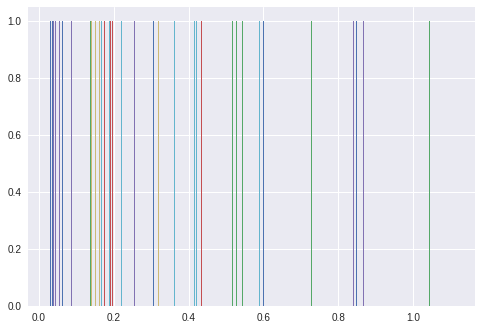

In [0]:
params['RMSE'].hist()

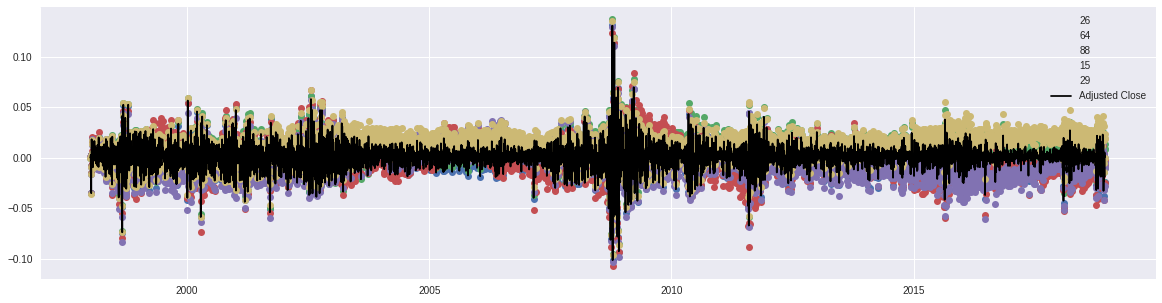

In [0]:
pro = pd.concat(processes, axis = 1)
pro.columns = list(range(len(pro.columns)))

indx = list(params['RMSE'].astype('float').nsmallest(5).index)

fig = pro[indx].plot(style = ['o']*5, figsize=(20,5))
X_t1.plot(ax = fig, color="black")

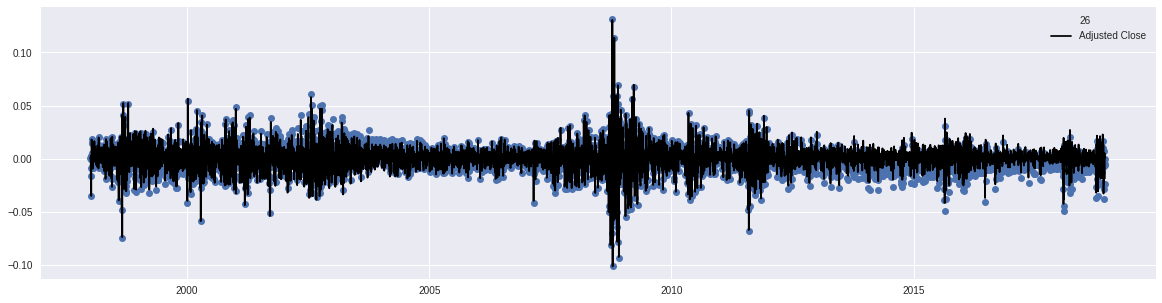

In [0]:
indx = list(params['RMSE'].astype('float').nsmallest(1).index)

fig = pro[indx].plot(style = ['o'], figsize=(20,5))
X_t1.plot(ax = fig, color="black")

### Forecasting Using the Ornstein-Uhlenbeck Process

In [0]:
def OU(theta, mu, sigma, initial, T, t):
  X_t = initial
  dt = 1 * (t/T)
  
  dXt = []
  
  for ite in range(T+1):
      dXt.append(X_t)
      mean_rev = theta*(mu - X_t)*dt
      Br = BrownianMotion().sample(t, zero = False)
      random = sigma*(Br)
      ou = mean_rev + X_t + random
      X_t = ou.values[0]
      
  return dXt

#### Monte Carlo Simulation of OU Processes

*   The first graph shows the simulated paths using the latest price as the starting point
*   The second graph shows the most likely path, which we get by taking the mean of all possible paths. This is taken as the forecast of SPY returns for the next thirty days.
* The last graph shows last years returns (solid line) with the forecasted returns (segmented line)

In [0]:
T = 30

def pred_dates(returns, n_ahead, offset):
  end = returns.index[-1]
  ahead = n_ahead
  off = offset

  final = [end]

  for i in range(ahead):
      end += pd.DateOffset(**off)
      final.append(end)

  return pd.DatetimeIndex(final)

pred = pred_dates(returns, T, {'days' : 1})

DatetimeIndex(['2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17',
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31', '2019-01-01', '2019-01-02',
               '2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-12', '2019-01-13'],
              dtype='datetime64[ns]', freq=None)

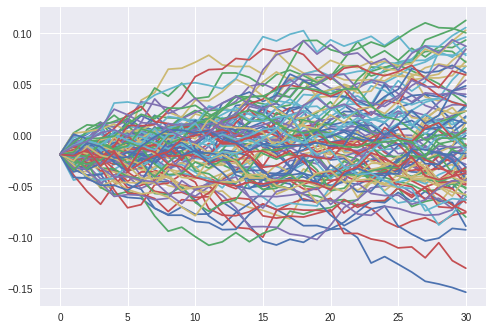

In [0]:
ous = pd.DataFrame(index = pred)


for i in range(maxiter):
  b = OU(theta, mu, sigma, initial, T, 1)
  ous[i] = b
  plt.plot(b)
  
plt.show()

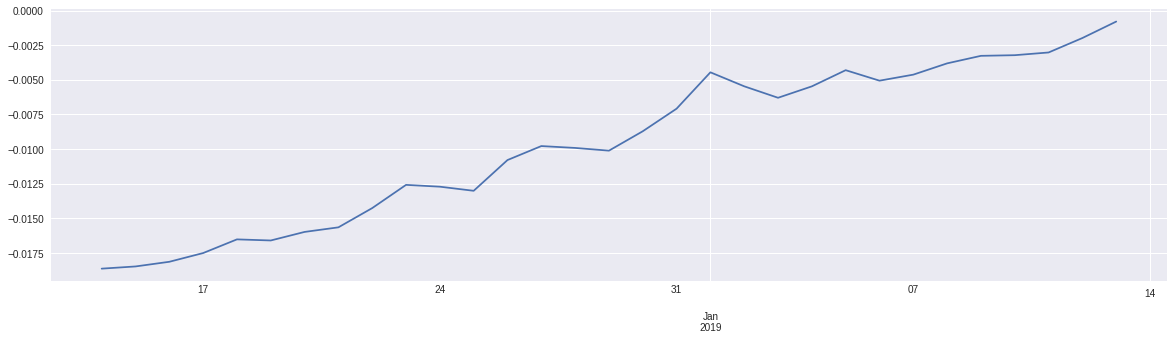

In [0]:
ous.mean(axis = 1).plot(figsize=(20,5))

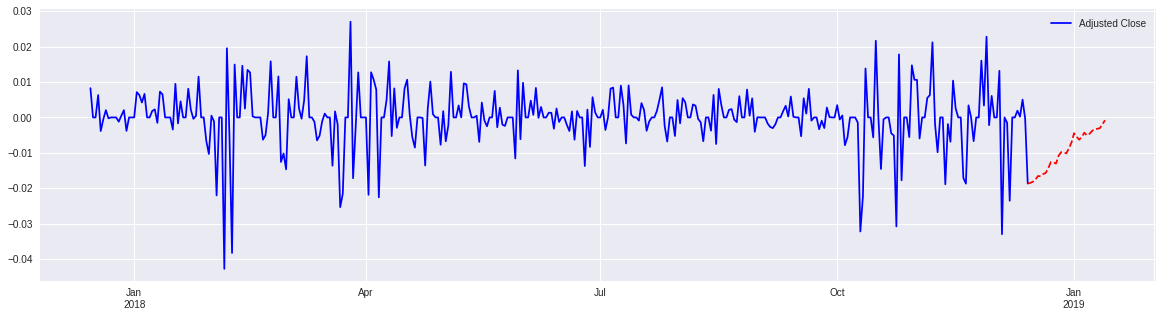

In [0]:
ax = returns.iloc[-365:].plot(ls="-", color="b", figsize=(20,5))
ous.mean(axis = 1).plot(ls="--", color="r", ax=ax)